In [1]:
import pandas as pd
import numpy as np

### Data

In [2]:
data1 = pd.read_csv('../../Data/Jeju/201901-202003.csv')
data1 = data1.fillna('')
data2 = pd.read_csv('../../Data/Jeju/202004.csv')
data2 = data2.fillna('')

In [3]:
data = pd.concat([data1, data2])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26048114 entries, 0 to 1350321
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   REG_YYMM      int64 
 1   CARD_SIDO_NM  object
 2   CARD_CCG_NM   object
 3   STD_CLSS_NM   object
 4   HOM_SIDO_NM   object
 5   HOM_CCG_NM    object
 6   AGE           object
 7   SEX_CTGO_CD   int64 
 8   FLC           int64 
 9   CSTMR_CNT     int64 
 10  AMT           int64 
 11  CNT           int64 
dtypes: int64(6), object(6)
memory usage: 2.5+ GB


#### 결측 처리

In [5]:
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

#### 18 사업체총조사

In [6]:
all_jobs_df = pd.read_csv('data/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [7]:
def local_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sigungus = sample_sido.CARD_CCG_NM.unique()
        for sigungu in sigungus:
            sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
            sum_arr = sample.iloc[:,3:].sum().values.reshape(1,-1)
            parcent_df = (sample.iloc[:,3:]/sum_arr)*100

            fin = pd.concat([sample.iloc[:,:3],parcent_df],axis=1)
            local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='LP')
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [8]:
def job_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = data.pivot_table(index = ['STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,3:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:3]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='JP')
    return job_percent_df

In [9]:
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)

#### 거래횟수와 이용고객과의 관계 (2019)

In [10]:
def cust_differ(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2019만 사용
    melt_plus = melt_plus[melt_plus.year == 2019]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2019만 사용
    melt_minus = melt_minus[melt_minus.year == 2019]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [11]:
trade_num_2019 = cust_differ(data)

#### 거래횟수와 이용고객과의 관계 (2020)

In [12]:
def cust_differ_2020(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2020만 사용
    melt_plus = melt_plus[melt_plus.year == 2020]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2020만 사용
    melt_minus = melt_minus[melt_minus.year == 2020]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [13]:
trade_num_2020 = cust_differ_2020(data)

In [14]:
trade_num = pd.concat([trade_num_2019, trade_num_2020])

In [15]:
trade_num.loyal = trade_num.loyal.fillna(-999)
trade_num.refund = trade_num.refund.fillna(999)

In [16]:
trade_num

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,loyal,month,refund
0,강원,건강보조식품 소매업,201901.0,80.0,1,-32.0
1,강원,골프장 운영업,201901.0,14890.0,1,999.0
2,강원,과실 및 채소 소매업,201901.0,7484.0,1,999.0
3,강원,관광 민예품 및 선물용품 소매업,201901.0,195.0,1,999.0
4,강원,그외 기타 분류안된 오락관련 서비스업,201901.0,-999.0,1,999.0
...,...,...,...,...,...,...
2575,충북,휴양콘도 운영업,202004.0,62.0,4,999.0
2576,대전,여행사업,202001.0,-999.0,1,999.0
2577,대전,여행사업,202002.0,-999.0,2,999.0
2578,대전,여행사업,202003.0,-999.0,3,999.0


#### 추가변수 결합

In [17]:
data.shape

(26048114, 13)

In [18]:
local_percent_df

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,REG_YYMM,LP
0,강원,강릉시,건강보조식품 소매업,201901,0.138432
1,강원,강릉시,골프장 운영업,201901,0.148825
2,강원,강릉시,과실 및 채소 소매업,201901,1.468549
3,강원,강릉시,관광 민예품 및 선물용품 소매업,201901,0.022661
4,강원,강릉시,그외 기타 스포츠시설 운영업,201901,0.003255
...,...,...,...,...,...
124523,충북,충주시,피자 햄버거 샌드위치 및 유사 음식점업,202004,1.362619
124524,충북,충주시,한식 음식점업,202004,18.402971
124525,충북,충주시,호텔업,202004,0.059226
124526,충북,충주시,화장품 및 방향제 소매업,202004,0.368080


In [19]:
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']
df = data.groupby(columns, as_index=False)[['AMT']].sum()

In [20]:
grouped = pd.merge(df,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
grouped = pd.merge(grouped,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped, trade_num, on =['CARD_SIDO_NM','STD_CLSS_NM','REG_YYMM'], how = 'left')

In [21]:
grouped.head(5)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,201901,강원,강릉시,건강보조식품 소매업,강원,20s,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,201901,강원,강릉시,건강보조식품 소매업,강원,30s,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,201901,강원,강릉시,건강보조식품 소매업,강원,30s,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0


In [22]:
grouped.REG_YYMM = pd.to_datetime(grouped.REG_YYMM, format='%Y%m')

In [23]:
from sklearn.preprocessing import LabelEncoder

# 인코딩
dtypes = grouped.dtypes
encoders = {}
for column in grouped.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(grouped[column])
        encoders[column] = encoder
        
df_num = grouped.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(grouped[column])

In [24]:
df_num

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,2019-01-01,0,4,0,0,2,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,2019-01-01,0,4,0,0,2,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,2019-01-01,0,4,0,0,3,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,2019-01-01,0,4,0,0,3,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630138,2020-04-01,16,202,40,16,1,1,1,77000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630139,2020-04-01,16,202,40,16,2,1,2,92000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630140,2020-04-01,16,202,40,16,3,2,3,193000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630141,2020-04-01,16,202,40,16,4,1,4,86000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0


In [25]:
import datetime as dt

df_num['month'] = df_num['REG_YYMM'].dt.month
df_num['year'] = df_num['REG_YYMM'].dt.year

In [59]:
train_df = df_num[df_num['REG_YYMM'] < '2020-01-01']
validation_df = df_num[(df_num['REG_YYMM'] > '2020-01-01') &(df_num['REG_YYMM'] < '2020-04-01')]

In [60]:
# 7월 데이터 = 2020년의 평균값을 사용.

temp = df_num[df_num['REG_YYMM'] >= '2020']
temp = temp.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()

In [61]:
temp.month = 7
temp = pd.concat([df_num[df_num['REG_YYMM'] == '2020-04-01'], temp])

In [62]:
temp = temp.drop(['REG_YYMM', 'AMT'], axis=1)

### 가족구성원 변수 삭제

In [63]:
train_df = train_df.drop(['FLC'], axis=1)
temp = temp.drop(['FLC'], axis=1)

In [64]:
validation_df = validation_df.drop(['FLC'], axis=1)

### Light GBM

In [65]:
import lightgbm as lgb

In [66]:
train_df.head(1)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,AMT,company,employee,LP,JP,loyal,month,refund,year
0,2019-01-01,0,4,0,0,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019


In [67]:
train = train_df.drop(['AMT', 'REG_YYMM'], axis=1)
trian_label = np.log1p(train_df[['AMT']])

In [68]:
validation = validation_df.drop(['AMT', 'REG_YYMM'], axis=1)
validation_label = np.log1p(validation_df[['AMT']])

In [69]:
lgb_train = lgb.Dataset(train, label=trian_label)
lgb_eval = lgb.Dataset(validation, label=validation_label, reference=lgb_train)

In [73]:
evals_result = {}
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth':11,
    'num_leaves': 31,
    'learning_rate': 0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [74]:
model = lgb.train(params, lgb_train, early_stopping_rounds=100,
                  num_boost_round=2000, evals_result=evals_result,
                  valid_sets= (lgb_train, lgb_eval),)

[1]	training's rmse: 2.02503	valid_1's rmse: 2.01106
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.94137	valid_1's rmse: 1.93359
[3]	training's rmse: 1.83087	valid_1's rmse: 1.81661
[4]	training's rmse: 1.77196	valid_1's rmse: 1.75807
[5]	training's rmse: 1.74893	valid_1's rmse: 1.73745
[6]	training's rmse: 1.72513	valid_1's rmse: 1.71247
[7]	training's rmse: 1.71432	valid_1's rmse: 1.70302
[8]	training's rmse: 1.70084	valid_1's rmse: 1.69044
[9]	training's rmse: 1.66257	valid_1's rmse: 1.64819
[10]	training's rmse: 1.65096	valid_1's rmse: 1.63629
[11]	training's rmse: 1.64119	valid_1's rmse: 1.62589
[12]	training's rmse: 1.63223	valid_1's rmse: 1.6167
[13]	training's rmse: 1.62344	valid_1's rmse: 1.60748
[14]	training's rmse: 1.61161	valid_1's rmse: 1.5963
[15]	training's rmse: 1.60058	valid_1's rmse: 1.58454
[16]	training's rmse: 1.59562	valid_1's rmse: 1.58622
[17]	training's rmse: 1.59041	valid_1's rmse: 1.5813
[18]	training's rmse: 1.58336	va

[152]	training's rmse: 1.32137	valid_1's rmse: 1.33319
[153]	training's rmse: 1.32068	valid_1's rmse: 1.33266
[154]	training's rmse: 1.32031	valid_1's rmse: 1.3323
[155]	training's rmse: 1.31978	valid_1's rmse: 1.33187
[156]	training's rmse: 1.31959	valid_1's rmse: 1.33179
[157]	training's rmse: 1.31788	valid_1's rmse: 1.32992
[158]	training's rmse: 1.31754	valid_1's rmse: 1.32991
[159]	training's rmse: 1.3173	valid_1's rmse: 1.33012
[160]	training's rmse: 1.31697	valid_1's rmse: 1.32983
[161]	training's rmse: 1.31641	valid_1's rmse: 1.32933
[162]	training's rmse: 1.316	valid_1's rmse: 1.32915
[163]	training's rmse: 1.31563	valid_1's rmse: 1.32899
[164]	training's rmse: 1.31518	valid_1's rmse: 1.32864
[165]	training's rmse: 1.31489	valid_1's rmse: 1.3283
[166]	training's rmse: 1.31459	valid_1's rmse: 1.32816
[167]	training's rmse: 1.31402	valid_1's rmse: 1.32775
[168]	training's rmse: 1.31293	valid_1's rmse: 1.32671
[169]	training's rmse: 1.31219	valid_1's rmse: 1.32597
[170]	training'

[303]	training's rmse: 1.27249	valid_1's rmse: 1.29573
[304]	training's rmse: 1.27239	valid_1's rmse: 1.29567
[305]	training's rmse: 1.27212	valid_1's rmse: 1.29538
[306]	training's rmse: 1.27181	valid_1's rmse: 1.29517
[307]	training's rmse: 1.27173	valid_1's rmse: 1.29502
[308]	training's rmse: 1.27157	valid_1's rmse: 1.29489
[309]	training's rmse: 1.27147	valid_1's rmse: 1.2948
[310]	training's rmse: 1.27127	valid_1's rmse: 1.29463
[311]	training's rmse: 1.27109	valid_1's rmse: 1.29442
[312]	training's rmse: 1.27019	valid_1's rmse: 1.29353
[313]	training's rmse: 1.27007	valid_1's rmse: 1.29352
[314]	training's rmse: 1.26996	valid_1's rmse: 1.29332
[315]	training's rmse: 1.26942	valid_1's rmse: 1.29274
[316]	training's rmse: 1.26927	valid_1's rmse: 1.29271
[317]	training's rmse: 1.26917	valid_1's rmse: 1.29275
[318]	training's rmse: 1.26868	valid_1's rmse: 1.29239
[319]	training's rmse: 1.26833	valid_1's rmse: 1.29214
[320]	training's rmse: 1.26794	valid_1's rmse: 1.29187
[321]	train

[454]	training's rmse: 1.24574	valid_1's rmse: 1.27664
[455]	training's rmse: 1.24566	valid_1's rmse: 1.27666
[456]	training's rmse: 1.24553	valid_1's rmse: 1.27658
[457]	training's rmse: 1.24545	valid_1's rmse: 1.27654
[458]	training's rmse: 1.24534	valid_1's rmse: 1.27652
[459]	training's rmse: 1.24528	valid_1's rmse: 1.2765
[460]	training's rmse: 1.24496	valid_1's rmse: 1.27634
[461]	training's rmse: 1.24488	valid_1's rmse: 1.27636
[462]	training's rmse: 1.24481	valid_1's rmse: 1.27633
[463]	training's rmse: 1.24471	valid_1's rmse: 1.27625
[464]	training's rmse: 1.24465	valid_1's rmse: 1.27619
[465]	training's rmse: 1.24461	valid_1's rmse: 1.27626
[466]	training's rmse: 1.24416	valid_1's rmse: 1.27589
[467]	training's rmse: 1.24411	valid_1's rmse: 1.27592
[468]	training's rmse: 1.24404	valid_1's rmse: 1.27587
[469]	training's rmse: 1.24392	valid_1's rmse: 1.27583
[470]	training's rmse: 1.24379	valid_1's rmse: 1.2757
[471]	training's rmse: 1.2437	valid_1's rmse: 1.27559
[472]	trainin

[605]	training's rmse: 1.22949	valid_1's rmse: 1.26629
[606]	training's rmse: 1.2293	valid_1's rmse: 1.26606
[607]	training's rmse: 1.22926	valid_1's rmse: 1.26603
[608]	training's rmse: 1.22921	valid_1's rmse: 1.2659
[609]	training's rmse: 1.22913	valid_1's rmse: 1.26586
[610]	training's rmse: 1.22908	valid_1's rmse: 1.26581
[611]	training's rmse: 1.22898	valid_1's rmse: 1.26577
[612]	training's rmse: 1.22875	valid_1's rmse: 1.26557
[613]	training's rmse: 1.22865	valid_1's rmse: 1.26555
[614]	training's rmse: 1.22851	valid_1's rmse: 1.26544
[615]	training's rmse: 1.22846	valid_1's rmse: 1.26556
[616]	training's rmse: 1.22838	valid_1's rmse: 1.26553
[617]	training's rmse: 1.22823	valid_1's rmse: 1.26545
[618]	training's rmse: 1.22816	valid_1's rmse: 1.26543
[619]	training's rmse: 1.2281	valid_1's rmse: 1.26538
[620]	training's rmse: 1.22796	valid_1's rmse: 1.26537
[621]	training's rmse: 1.22788	valid_1's rmse: 1.26536
[622]	training's rmse: 1.2277	valid_1's rmse: 1.2652
[623]	training'

[756]	training's rmse: 1.21632	valid_1's rmse: 1.25822
[757]	training's rmse: 1.21627	valid_1's rmse: 1.2582
[758]	training's rmse: 1.21616	valid_1's rmse: 1.2581
[759]	training's rmse: 1.21611	valid_1's rmse: 1.25807
[760]	training's rmse: 1.21606	valid_1's rmse: 1.25806
[761]	training's rmse: 1.21602	valid_1's rmse: 1.2581
[762]	training's rmse: 1.21595	valid_1's rmse: 1.25805
[763]	training's rmse: 1.21589	valid_1's rmse: 1.25807
[764]	training's rmse: 1.21586	valid_1's rmse: 1.25806
[765]	training's rmse: 1.21584	valid_1's rmse: 1.25807
[766]	training's rmse: 1.21579	valid_1's rmse: 1.25802
[767]	training's rmse: 1.21568	valid_1's rmse: 1.25793
[768]	training's rmse: 1.21556	valid_1's rmse: 1.25777
[769]	training's rmse: 1.21549	valid_1's rmse: 1.25771
[770]	training's rmse: 1.2154	valid_1's rmse: 1.25762
[771]	training's rmse: 1.21537	valid_1's rmse: 1.25757
[772]	training's rmse: 1.21534	valid_1's rmse: 1.25756
[773]	training's rmse: 1.21527	valid_1's rmse: 1.25755
[774]	training

[905]	training's rmse: 1.20687	valid_1's rmse: 1.25279
[906]	training's rmse: 1.20681	valid_1's rmse: 1.25277
[907]	training's rmse: 1.20674	valid_1's rmse: 1.25275
[908]	training's rmse: 1.20671	valid_1's rmse: 1.25272
[909]	training's rmse: 1.20662	valid_1's rmse: 1.25265
[910]	training's rmse: 1.20656	valid_1's rmse: 1.25271
[911]	training's rmse: 1.20648	valid_1's rmse: 1.25262
[912]	training's rmse: 1.20635	valid_1's rmse: 1.25249
[913]	training's rmse: 1.20633	valid_1's rmse: 1.25249
[914]	training's rmse: 1.20627	valid_1's rmse: 1.25244
[915]	training's rmse: 1.20626	valid_1's rmse: 1.25243
[916]	training's rmse: 1.20618	valid_1's rmse: 1.25243
[917]	training's rmse: 1.2061	valid_1's rmse: 1.25242
[918]	training's rmse: 1.20602	valid_1's rmse: 1.25236
[919]	training's rmse: 1.20598	valid_1's rmse: 1.25239
[920]	training's rmse: 1.20596	valid_1's rmse: 1.25247
[921]	training's rmse: 1.20575	valid_1's rmse: 1.25229
[922]	training's rmse: 1.2057	valid_1's rmse: 1.25227
[923]	traini

[1053]	training's rmse: 1.19887	valid_1's rmse: 1.24805
[1054]	training's rmse: 1.19884	valid_1's rmse: 1.24808
[1055]	training's rmse: 1.1988	valid_1's rmse: 1.24809
[1056]	training's rmse: 1.19875	valid_1's rmse: 1.24808
[1057]	training's rmse: 1.19872	valid_1's rmse: 1.24814
[1058]	training's rmse: 1.19869	valid_1's rmse: 1.24808
[1059]	training's rmse: 1.19864	valid_1's rmse: 1.24808
[1060]	training's rmse: 1.19856	valid_1's rmse: 1.24804
[1061]	training's rmse: 1.19845	valid_1's rmse: 1.24791
[1062]	training's rmse: 1.19842	valid_1's rmse: 1.24795
[1063]	training's rmse: 1.19838	valid_1's rmse: 1.24793
[1064]	training's rmse: 1.19832	valid_1's rmse: 1.24788
[1065]	training's rmse: 1.19828	valid_1's rmse: 1.2479
[1066]	training's rmse: 1.19825	valid_1's rmse: 1.24786
[1067]	training's rmse: 1.19821	valid_1's rmse: 1.24783
[1068]	training's rmse: 1.1982	valid_1's rmse: 1.2478
[1069]	training's rmse: 1.19812	valid_1's rmse: 1.24773
[1070]	training's rmse: 1.19805	valid_1's rmse: 1.24

[1200]	training's rmse: 1.19315	valid_1's rmse: 1.24534
[1201]	training's rmse: 1.1931	valid_1's rmse: 1.24528
[1202]	training's rmse: 1.19303	valid_1's rmse: 1.24522
[1203]	training's rmse: 1.19296	valid_1's rmse: 1.24519
[1204]	training's rmse: 1.19288	valid_1's rmse: 1.24506
[1205]	training's rmse: 1.19287	valid_1's rmse: 1.245
[1206]	training's rmse: 1.19282	valid_1's rmse: 1.24495
[1207]	training's rmse: 1.1928	valid_1's rmse: 1.24496
[1208]	training's rmse: 1.19276	valid_1's rmse: 1.24493
[1209]	training's rmse: 1.19274	valid_1's rmse: 1.24489
[1210]	training's rmse: 1.19272	valid_1's rmse: 1.24489
[1211]	training's rmse: 1.19266	valid_1's rmse: 1.24488
[1212]	training's rmse: 1.19265	valid_1's rmse: 1.24491
[1213]	training's rmse: 1.19263	valid_1's rmse: 1.24498
[1214]	training's rmse: 1.1926	valid_1's rmse: 1.24501
[1215]	training's rmse: 1.19258	valid_1's rmse: 1.24501
[1216]	training's rmse: 1.19256	valid_1's rmse: 1.24498
[1217]	training's rmse: 1.19252	valid_1's rmse: 1.244

[1349]	training's rmse: 1.18728	valid_1's rmse: 1.24242
[1350]	training's rmse: 1.18727	valid_1's rmse: 1.24242
[1351]	training's rmse: 1.18725	valid_1's rmse: 1.24238
[1352]	training's rmse: 1.18723	valid_1's rmse: 1.24236
[1353]	training's rmse: 1.18713	valid_1's rmse: 1.24226
[1354]	training's rmse: 1.18709	valid_1's rmse: 1.24222
[1355]	training's rmse: 1.18699	valid_1's rmse: 1.2421
[1356]	training's rmse: 1.18695	valid_1's rmse: 1.24211
[1357]	training's rmse: 1.18693	valid_1's rmse: 1.24208
[1358]	training's rmse: 1.1868	valid_1's rmse: 1.24194
[1359]	training's rmse: 1.18676	valid_1's rmse: 1.2419
[1360]	training's rmse: 1.18671	valid_1's rmse: 1.24187
[1361]	training's rmse: 1.18662	valid_1's rmse: 1.24182
[1362]	training's rmse: 1.18657	valid_1's rmse: 1.24174
[1363]	training's rmse: 1.18655	valid_1's rmse: 1.24172
[1364]	training's rmse: 1.18652	valid_1's rmse: 1.24171
[1365]	training's rmse: 1.1865	valid_1's rmse: 1.24171
[1366]	training's rmse: 1.18645	valid_1's rmse: 1.24

[1495]	training's rmse: 1.18186	valid_1's rmse: 1.23895
[1496]	training's rmse: 1.18184	valid_1's rmse: 1.23888
[1497]	training's rmse: 1.18183	valid_1's rmse: 1.23885
[1498]	training's rmse: 1.18177	valid_1's rmse: 1.23883
[1499]	training's rmse: 1.18175	valid_1's rmse: 1.23883
[1500]	training's rmse: 1.18173	valid_1's rmse: 1.23875
[1501]	training's rmse: 1.18172	valid_1's rmse: 1.23877
[1502]	training's rmse: 1.18168	valid_1's rmse: 1.23876
[1503]	training's rmse: 1.18165	valid_1's rmse: 1.23874
[1504]	training's rmse: 1.18164	valid_1's rmse: 1.23874
[1505]	training's rmse: 1.18158	valid_1's rmse: 1.23867
[1506]	training's rmse: 1.18155	valid_1's rmse: 1.23867
[1507]	training's rmse: 1.18153	valid_1's rmse: 1.23867
[1508]	training's rmse: 1.18149	valid_1's rmse: 1.23864
[1509]	training's rmse: 1.18148	valid_1's rmse: 1.23864
[1510]	training's rmse: 1.18146	valid_1's rmse: 1.23865
[1511]	training's rmse: 1.18143	valid_1's rmse: 1.2386
[1512]	training's rmse: 1.18139	valid_1's rmse: 1

[1642]	training's rmse: 1.17756	valid_1's rmse: 1.23687
[1643]	training's rmse: 1.17754	valid_1's rmse: 1.23686
[1644]	training's rmse: 1.17752	valid_1's rmse: 1.23685
[1645]	training's rmse: 1.17748	valid_1's rmse: 1.23683
[1646]	training's rmse: 1.17741	valid_1's rmse: 1.23684
[1647]	training's rmse: 1.1774	valid_1's rmse: 1.23688
[1648]	training's rmse: 1.17739	valid_1's rmse: 1.23689
[1649]	training's rmse: 1.17737	valid_1's rmse: 1.23691
[1650]	training's rmse: 1.17735	valid_1's rmse: 1.2369
[1651]	training's rmse: 1.17734	valid_1's rmse: 1.23683
[1652]	training's rmse: 1.17732	valid_1's rmse: 1.2368
[1653]	training's rmse: 1.17727	valid_1's rmse: 1.23676
[1654]	training's rmse: 1.17724	valid_1's rmse: 1.23673
[1655]	training's rmse: 1.17719	valid_1's rmse: 1.23669
[1656]	training's rmse: 1.17717	valid_1's rmse: 1.23662
[1657]	training's rmse: 1.17715	valid_1's rmse: 1.23658
[1658]	training's rmse: 1.17715	valid_1's rmse: 1.23653
[1659]	training's rmse: 1.17711	valid_1's rmse: 1.2

[1790]	training's rmse: 1.17389	valid_1's rmse: 1.23544
[1791]	training's rmse: 1.17388	valid_1's rmse: 1.23546
[1792]	training's rmse: 1.17386	valid_1's rmse: 1.23547
[1793]	training's rmse: 1.17385	valid_1's rmse: 1.2355
[1794]	training's rmse: 1.17377	valid_1's rmse: 1.23544
[1795]	training's rmse: 1.17375	valid_1's rmse: 1.23542
[1796]	training's rmse: 1.17374	valid_1's rmse: 1.23542
[1797]	training's rmse: 1.17372	valid_1's rmse: 1.23542
[1798]	training's rmse: 1.17369	valid_1's rmse: 1.23539
[1799]	training's rmse: 1.17365	valid_1's rmse: 1.23537
[1800]	training's rmse: 1.17362	valid_1's rmse: 1.23538
[1801]	training's rmse: 1.1736	valid_1's rmse: 1.23537
[1802]	training's rmse: 1.17357	valid_1's rmse: 1.23534
[1803]	training's rmse: 1.17356	valid_1's rmse: 1.23533
[1804]	training's rmse: 1.17354	valid_1's rmse: 1.23534
[1805]	training's rmse: 1.17352	valid_1's rmse: 1.23533
[1806]	training's rmse: 1.1735	valid_1's rmse: 1.23538
[1807]	training's rmse: 1.17345	valid_1's rmse: 1.2

[1937]	training's rmse: 1.17021	valid_1's rmse: 1.23356
[1938]	training's rmse: 1.1702	valid_1's rmse: 1.23356
[1939]	training's rmse: 1.17018	valid_1's rmse: 1.23355
[1940]	training's rmse: 1.17016	valid_1's rmse: 1.23352
[1941]	training's rmse: 1.17015	valid_1's rmse: 1.23352
[1942]	training's rmse: 1.17014	valid_1's rmse: 1.23353
[1943]	training's rmse: 1.17014	valid_1's rmse: 1.23352
[1944]	training's rmse: 1.17011	valid_1's rmse: 1.23352
[1945]	training's rmse: 1.17009	valid_1's rmse: 1.23352
[1946]	training's rmse: 1.17008	valid_1's rmse: 1.23353
[1947]	training's rmse: 1.17007	valid_1's rmse: 1.23354
[1948]	training's rmse: 1.17006	valid_1's rmse: 1.23354
[1949]	training's rmse: 1.17005	valid_1's rmse: 1.23353
[1950]	training's rmse: 1.17	valid_1's rmse: 1.23349
[1951]	training's rmse: 1.16996	valid_1's rmse: 1.23348
[1952]	training's rmse: 1.16995	valid_1's rmse: 1.23347
[1953]	training's rmse: 1.16993	valid_1's rmse: 1.2335
[1954]	training's rmse: 1.16992	valid_1's rmse: 1.233

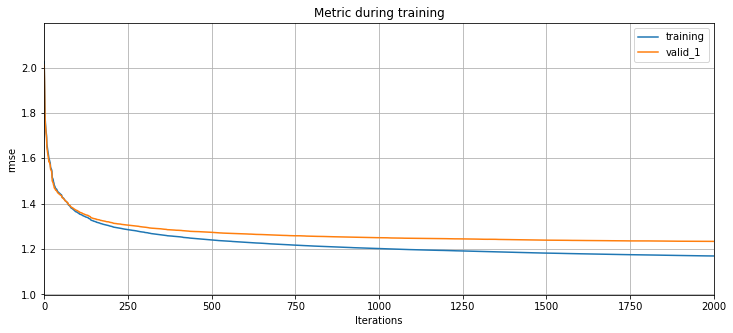

In [75]:
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline

lgb.plot_metric(evals_result, figsize=(12, 5))

In [76]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [77]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [78]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv('../../Data/Jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,6.808266e+07
1,202004,강원,골프장 운영업,2.807110e+09
2,202004,강원,과실 및 채소 소매업,8.171663e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.293441e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


In [79]:
submission.to_csv('submission/submission lgbm 0728 non FLC 2.csv', encoding='utf-8-sig')